In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import string
import xarray as xr

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

import sys
sys.path.insert(0, '/home/561/jn8053/~/.local/lib')
from xarrayMannKendall import *

clnt = dsk.Client()
clnt

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/43573/status,
Dashboard: /proxy/43573/status,Workers: 4
Total threads: 16,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36665,Workers: 4
Dashboard: /proxy/43573/status,Total threads: 16
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:34171,Total threads: 4
Dashboard: /proxy/44107/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:36939,


In [2]:
keys = ['erai', 'era5', 'cfsr', 'jra55', 'reanalysis', 'cmip6']

In [3]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

# Divide line calculated as:
# cset = plt.contour(mask['lon'][1:], mask['lat'], xr.where(np.isnan(mask[:,1:]), 1, 0), levels = [0]); plt.close()
# div_lin = np.array([cset.allsegs[0][1][:,0], cset.allsegs[0][1][:,1]])
div_line = xr.open_dataset('../data/smooth_div_line.nc')['__xarray_dataarray_variable__']

In [4]:
uas = {}
vas = {}
psl = {}
for k in keys:
    uas[k] = xr.open_dataset('../data/uas-monthly-1979_2015-'+k+'.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
    vas[k] = xr.open_dataset('../data/vas-monthly-1979_2015-'+k+'.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))
    psl[k] = xr.open_dataset('../data/psl-monthly-1979_2015-'+k+'.nc')['psl'].sel(time = slice('1979-01-01', '2015-01-01'))

In [5]:
uas_ssp45 = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp45.nc')['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
vas_ssp45 = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp45.nc')['vas'].sel(time = slice('2015-01-01', '2100-01-01'))
psl_ssp45 = xr.open_dataset('../data/psl-monthly-2015_2100-cmip6ssp45.nc')['psl'].sel(time = slice('2015-01-01', '2100-01-01'))

uas_ssp85 = xr.open_dataset('../data/uas-monthly-2015_2100-cmip6ssp85.nc')['uas'].sel(time = slice('2015-01-01', '2100-01-01'))
vas_ssp85 = xr.open_dataset('../data/vas-monthly-2015_2100-cmip6ssp85.nc')['vas'].sel(time = slice('2015-01-01', '2100-01-01'))
psl_ssp85 = xr.open_dataset('../data/psl-monthly-2015_2100-cmip6ssp85.nc')['psl'].sel(time = slice('2015-01-01', '2100-01-01'))

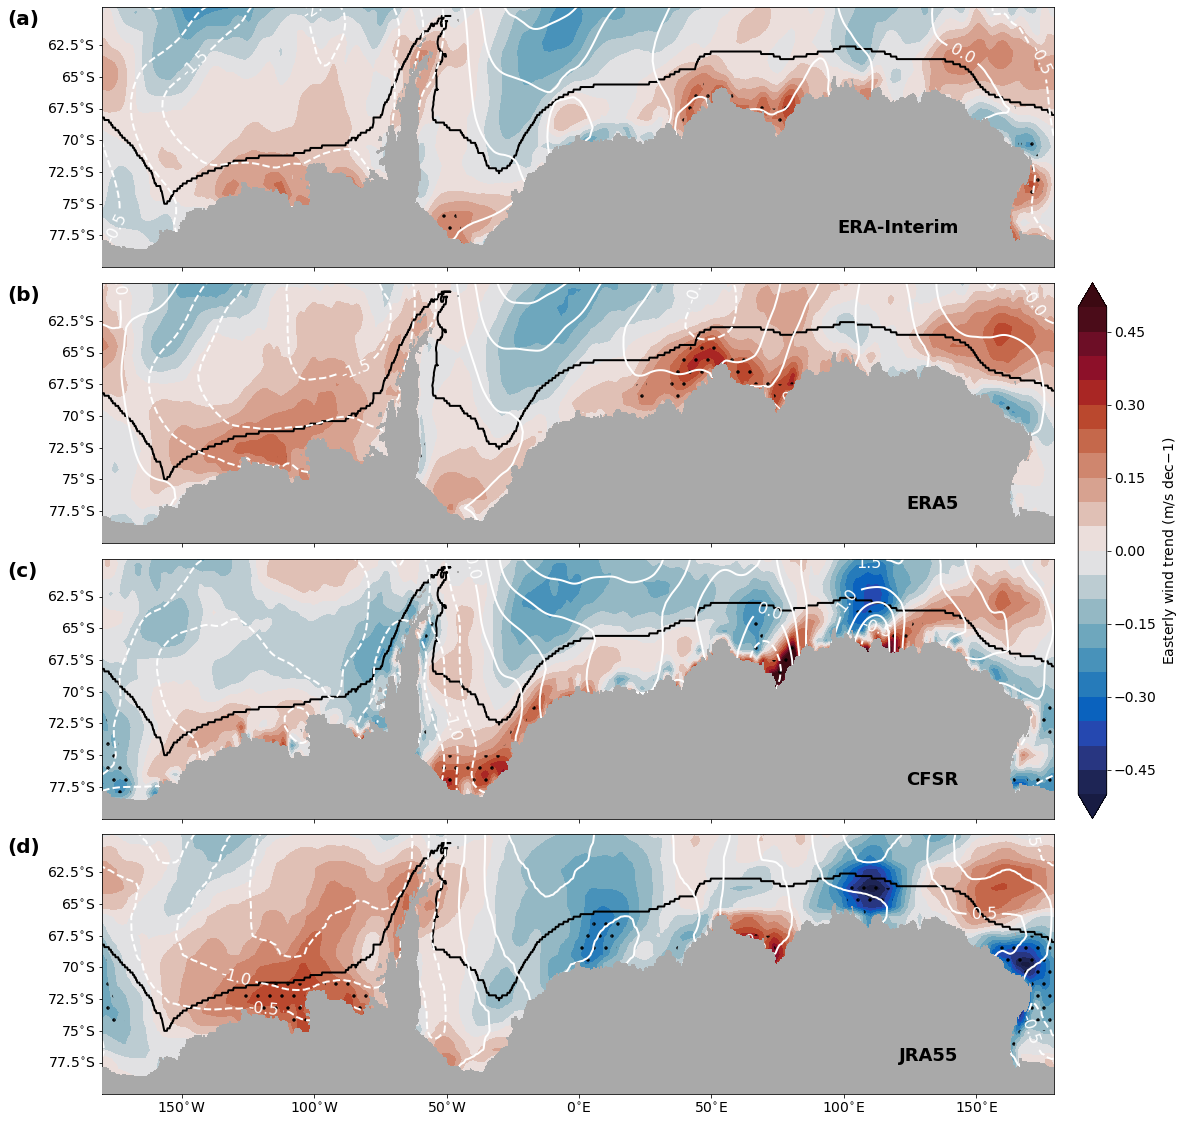

In [30]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 20))
gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.03], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[1:3,1])]
n = 0
for ax, label in zip(axs[:-1], ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']):
    ax.text(-0.1, .93,  '('+string.ascii_lowercase[n]+')', transform = ax.transAxes, size = 20, weight = 'bold')
    ax.text(0.9, .13, label, ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold', zorder = 5)
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1], axs[2]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'darkgrey', 
                linewidths = 0.5, zorder = 3)
    ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
    n += 1
n = 0
for k in keys[:-2]:
    cf = axs[n].contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], -uas_trends[k]['trend']*10, 
                         levels = np.arange(-.5, .55, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], 
                    xr.where(np.isnan(mask), np.nan, 1).interp(lat = vas[k]['lat'], lon = vas[k]['lon'])*uas_trends[k]['p'].where(uas_trends[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    c = axs[n].contour(psl_historical_re[k]['lon'], psl_historical_re[k]['lat'], psl_historical_re[k]/100,
                       levels = np.arange(-3, 3.5, .5), colors = ['white'], linewidths = [2], zorder = 2)
    axs[n].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=16, zorder = 2)
    n += 1
fig.colorbar(cf, cax = axs[-1]).set_label('Easterly wind trend (m/s dec${-1}$)')

plt.savefig('../results/v6/sup_reanalysis_trends_uas.jpg', bbox_inches = 'tight', dpi = 800)

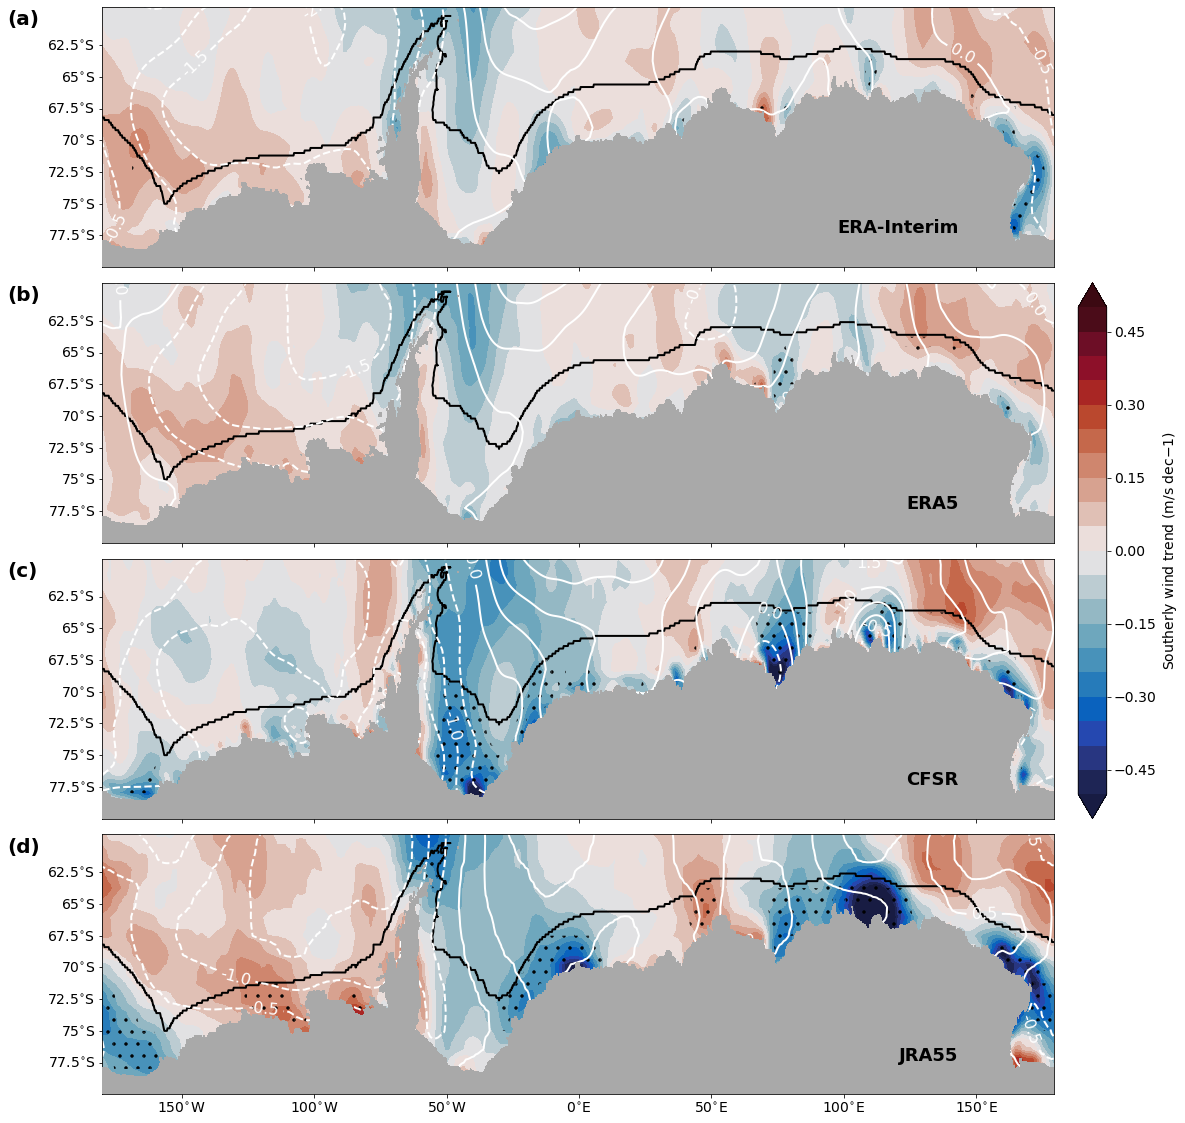

In [29]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 20))
gr = gs.GridSpec(4, 2, figure = fig, width_ratios = [1,.03], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[1,0]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[1:3,1])]
n = 0
for ax, label in zip(axs[:-1], ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55']):
    ax.text(-0.1, .93,  '('+string.ascii_lowercase[n]+')', transform = ax.transAxes, size = 20, weight = 'bold')
    ax.text(0.9, .13, label, ha = 'right', transform = ax.transAxes, size = 18, weight = 'bold', zorder = 5)
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-77.5, -60, 2.5))
    ax.set_yticklabels(['77.5$^{\circ}$S', '75$^{\circ}$S', '72.5$^{\circ}$S', '70$^{\circ}$S', 
                        '67.5$^{\circ}$S', '65$^{\circ}$S', '62.5$^{\circ}$S'])
    if ax in [axs[0], axs[1], axs[2]]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'darkgrey', 
                linewidths = 0.5, zorder = 3)
    ax.plot(div_line[0], div_line[1], 'k', linewidth = 2, zorder = 2)
    n += 1
n = 0
for k in keys[:-2]:
    cf = axs[n].contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], vas_trends[k]['trend']*10, 
                         levels = np.arange(-.5, .55, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], 
                    xr.where(np.isnan(mask), np.nan, 1).interp(lat = vas[k]['lat'], lon = vas[k]['lon'])*vas_trends[k]['p'].where(vas_trends[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    c = axs[n].contour(psl_historical_re[k]['lon'], psl_historical_re[k]['lat'], psl_historical_re[k]/100,
                       levels = np.arange(-3, 3.5, .5), colors = ['white'], linewidths = [2], zorder = 2)
    axs[n].clabel(c, c.levels, inline=True, fmt='%1.1f', fontsize=16, zorder = 2)
    n += 1
fig.colorbar(cf, cax = axs[-1]).set_label('Southerly wind trend (m/s dec${-1}$)')

plt.savefig('../results/v6/sup_reanalysis_trends_vas.jpg', bbox_inches = 'tight', dpi = 800)

In [31]:
path_uas = glob.glob('../data/cmip6-regridded/uas_hist*')
path_vas = glob.glob('../data/cmip6-regridded/vas_hist*')
path_psl = glob.glob('../data/cmip6-regridded/psl_hist*')
uas_cmip = {}; vas_cmip = {}; psl_cmip = {}
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_cmip[model_name] = xr.open_dataset(path_uas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['uas']
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_cmip[model_name] = xr.open_dataset(path_vas[i]).sel(time = slice('1979-01-01', '2015-01-01'))['vas']
    
    model_name = path_psl[i].split('/')[-1].split('_')[-1].split('.')[0]
    psl_cmip[model_name] = xr.open_dataset(path_psl[i]).sel(time = slice('1979-01-01', '2015-01-01'))['psl']
model_keys = list(uas_cmip.keys())

In [32]:
uas_cmip_trends = {}; vas_cmip_trends = {}
for k in model_keys:
    u = uas_cmip[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_cmip_trends[k] = MK_class.compute()
    uas_cmip_trends[k] = uas_cmip_trends[k].rename({'x':'lon', 'y':'lat'})
    
    v = vas_cmip[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_cmip_trends[k] = MK_class.compute()
    vas_cmip_trends[k] = vas_cmip_trends[k].rename({'x':'lon', 'y':'lat'})
    
    print(k)

INM-CM4-8
MRI-ESM2-0
NESM3
IITM-ESM
INM-CM5-0
KACE-1-0-G
GFDL-CM4
MIROC6
EC-Earth3-Veg-LR
MPI-ESM1-2-LR
EC-Earth3-CC
EC-Earth3-Veg
IPSL-CM6A-LR
AWI-CM-1-1-MR
GFDL-ESM4
BCC-CSM2-MR
EC-Earth3
FGOALS-f3-L
CanESM5


In [33]:
psl_anom = {}
for k in model_keys:
    psl_anom[k] = psl_cmip[k].sel(time = slice('2005-01-01', '2015-01-01')).mean('time') - \
                  psl_cmip[k].sel(time = slice('1979-01-01', '1989-01-01')).mean('time')

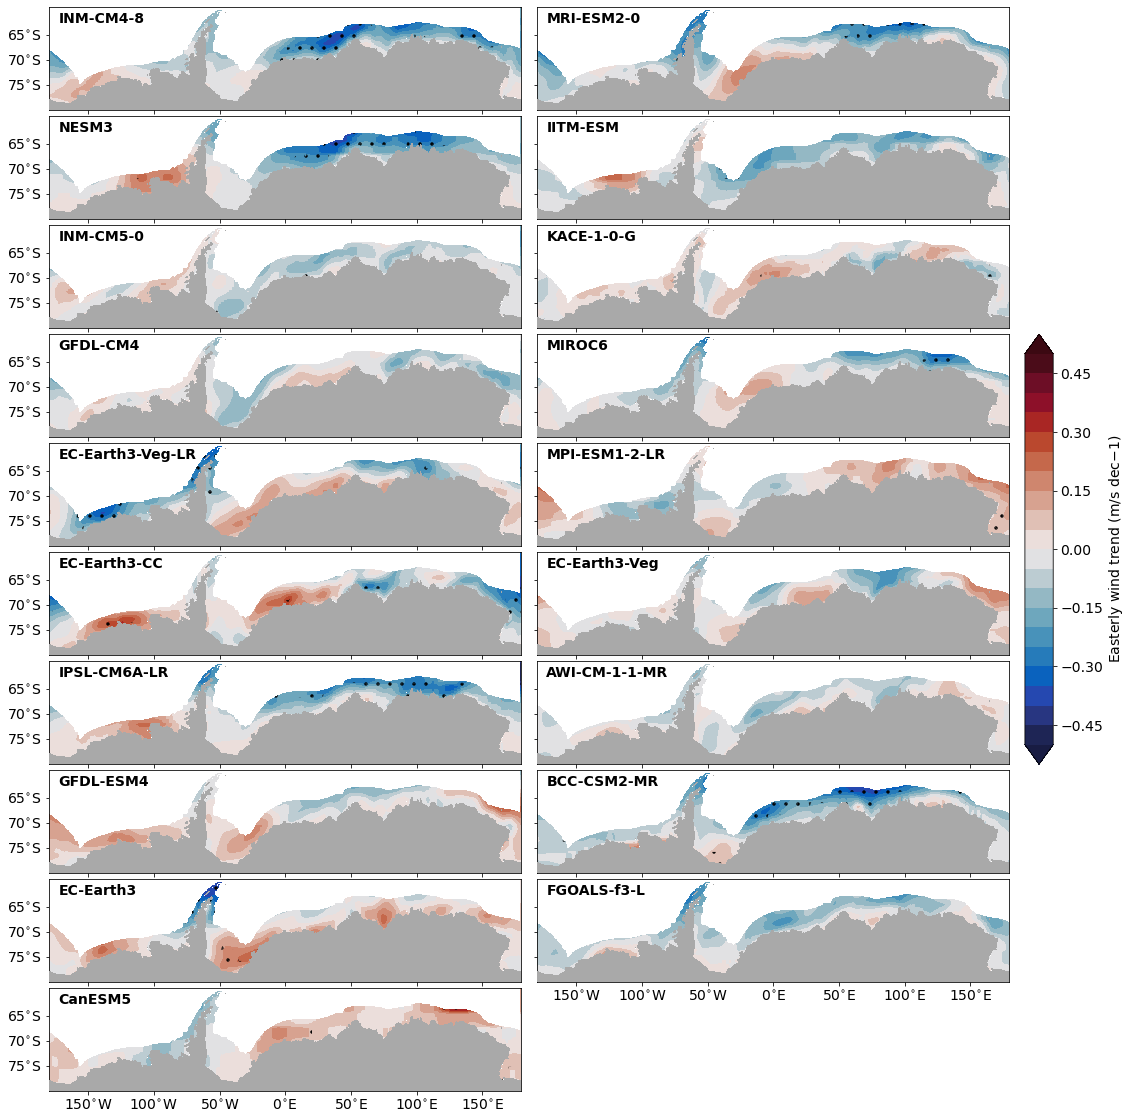

In [34]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 40))
gr = gs.GridSpec(20, 3, figure = fig, width_ratios = [1,1,.06], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,0]), 
       fig.add_subplot(gr[1,1]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[2,1]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[3,1]),
       fig.add_subplot(gr[4,0]),
       fig.add_subplot(gr[4,1]),
       fig.add_subplot(gr[5,0]), 
       fig.add_subplot(gr[5,1]),
       fig.add_subplot(gr[6,0]),
       fig.add_subplot(gr[6,1]),
       fig.add_subplot(gr[7,0]), 
       fig.add_subplot(gr[7,1]),
       fig.add_subplot(gr[8,0]),
       fig.add_subplot(gr[8,1]),
       fig.add_subplot(gr[9,0]),
       fig.add_subplot(gr[3:7,2])]
for ax, label in zip(axs[:-1], model_keys):
    ax.text(0.9, .13, label, ha = 'right', transform = ax.transAxes, size = 14, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-75, -60,5))
    if ax in [axs[0], axs[2], axs[4], axs[6], axs[8], axs[10], axs[10], axs[12], axs[14], axs[16], axs[18]]:
        ax.set_yticklabels(['75$^{\circ}$S', '70$^{\circ}$S', '65$^{\circ}$S'])
    else:
        ax.set_yticklabels([])
    if ax in axs[:2]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'darkgrey', 
                linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, vmax = 1.1, 
                  cmap = 'binary', zorder = 2)
    
n = 0
for k in model_keys:
    ax.text(0.02, .85, k, transform = axs[n].transAxes, size = 14, weight = 'bold')
    cf = axs[n].contourf(uas_cmip_trends[k]['lon'], uas_cmip_trends[k]['lat'], -uas_cmip_trends[k]['trend']*10, 
                         levels = np.arange(-.5, .55, .05), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(uas_cmip_trends[k]['lon'], uas_cmip_trends[k]['lat'], 
                    uas_cmip_trends[k]['p'].where(uas_cmip_trends[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    n += 1
fig.colorbar(cf, cax = axs[-1]).set_label('Easterly wind trend (m/s dec${-1}$)')

plt.savefig('../results/v6/sup_cmip6ind_trends_historical_uas.jpg', bbox_inches = 'tight', dpi = 800)

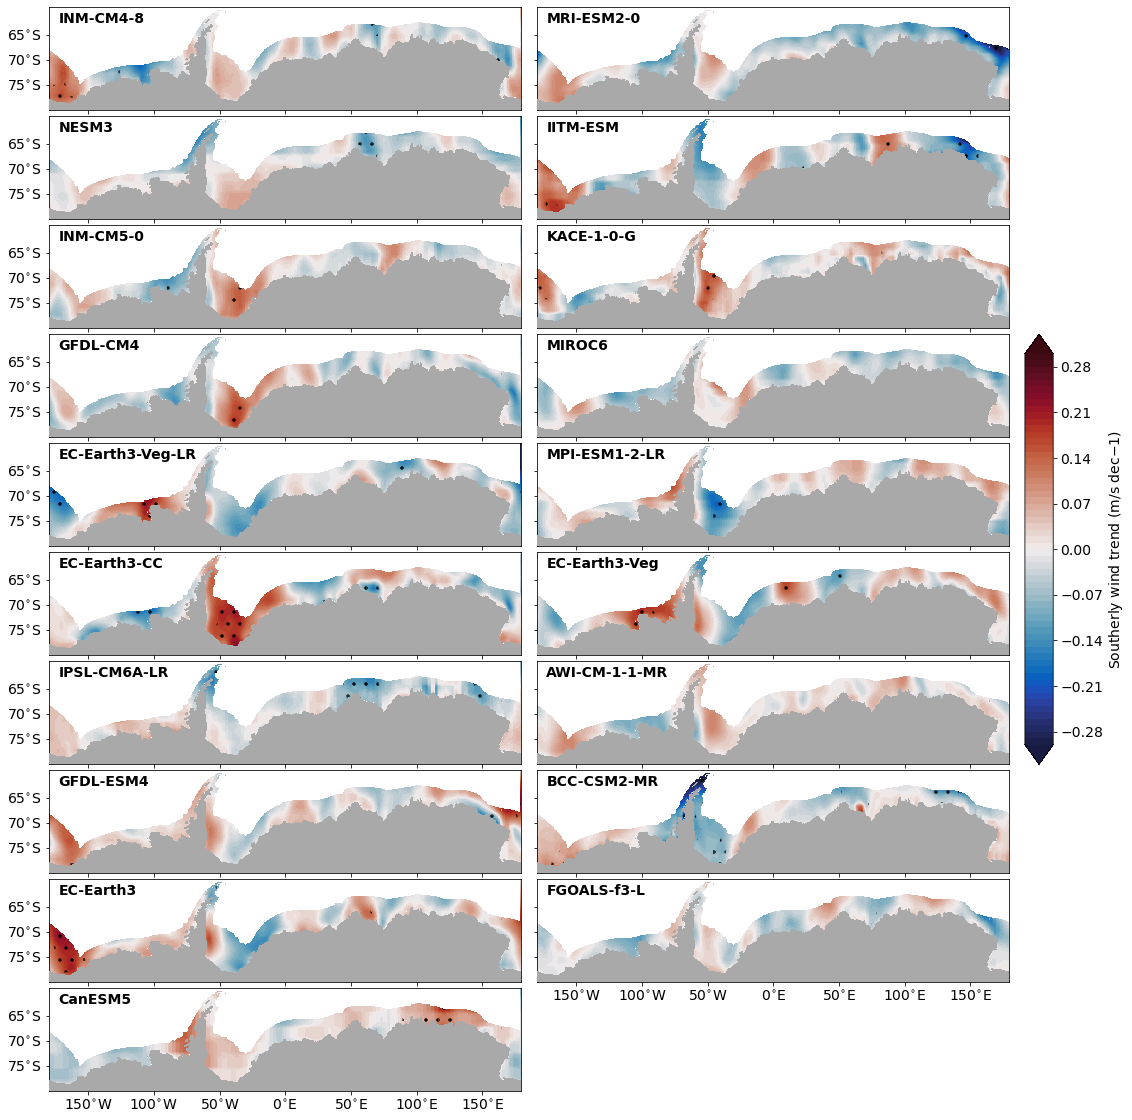

In [37]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (18, 40))
gr = gs.GridSpec(20, 3, figure = fig, width_ratios = [1,1,.06], hspace = .06, wspace = 0.05)
axs = [fig.add_subplot(gr[0,0]),
       fig.add_subplot(gr[0,1]),
       fig.add_subplot(gr[1,0]), 
       fig.add_subplot(gr[1,1]),
       fig.add_subplot(gr[2,0]),
       fig.add_subplot(gr[2,1]),
       fig.add_subplot(gr[3,0]), 
       fig.add_subplot(gr[3,1]),
       fig.add_subplot(gr[4,0]),
       fig.add_subplot(gr[4,1]),
       fig.add_subplot(gr[5,0]), 
       fig.add_subplot(gr[5,1]),
       fig.add_subplot(gr[6,0]),
       fig.add_subplot(gr[6,1]),
       fig.add_subplot(gr[7,0]), 
       fig.add_subplot(gr[7,1]),
       fig.add_subplot(gr[8,0]),
       fig.add_subplot(gr[8,1]),
       fig.add_subplot(gr[9,0]),
       fig.add_subplot(gr[3:7,2])]
for ax, label in zip(axs[:-1], model_keys):
    ax.text(0.9, .13, label, ha = 'right', transform = ax.transAxes, size = 14, weight = 'bold')
    ax.set_xlim([-180, 179.25])
    ax.set_ylim([-80, -59.5])
    ax.set_yticks(np.arange(-75, -60,5))
    if ax in [axs[0], axs[2], axs[4], axs[6], axs[8], axs[10], axs[10], axs[12], axs[14], axs[16], axs[18]]:
        ax.set_yticklabels(['75$^{\circ}$S', '70$^{\circ}$S', '65$^{\circ}$S'])
    else:
        ax.set_yticklabels([])
    if ax in axs[:2]:
        ax.set_xticklabels([])
    else:
        ax.set_xticks(np.arange(-150, 200, 50))
        ax.set_xticklabels(['150$^{\circ}$W', '100$^{\circ}$W', '50$^{\circ}$W', '0$^{\circ}$E', 
                            '50$^{\circ}$E', '100$^{\circ}$E', '150$^{\circ}$E'])
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, colors = 'darkgrey', 
                linewidths = 0.5, zorder = 3)
    ax.pcolormesh(mask['lon'], mask['lat'], xr.where(np.isnan(mask), 1, np.nan), vmin = 1, vmax = 1.1, 
                  cmap = 'binary', zorder = 2)
    
n = 0
for k in model_keys:
    ax.text(0.02, .85, k, transform = axs[n].transAxes, size = 14, weight = 'bold')
    cf = axs[n].contourf(uas_cmip_trends[k]['lon'], uas_cmip_trends[k]['lat'], vas_cmip_trends[k]['trend']*10, 
                         levels = np.arange(-.3, .31, .01), extend = 'both', cmap = cmocean.cm.balance)
    axs[n].contourf(uas_cmip_trends[k]['lon'], uas_cmip_trends[k]['lat'], 
                    vas_cmip_trends[k]['p'].where(vas_cmip_trends[k]['p'] <= .05),
                    colors = ['none'], hatches = ['.'])
    n += 1
fig.colorbar(cf, cax = axs[-1]).set_label('Southerly wind trend (m/s dec${-1}$)')

plt.savefig('../results/v6/sup_cmip6ind_trends_historical_vas.jpg', bbox_inches = 'tight', dpi = 800)